In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers, optimizers, regularizers
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [2]:
row_X = pd.read_csv('.\\articles_ko_samsung.csv', encoding='utf-8', sep=',')
row_y = pd.read_csv('.\\label_ko_samsung.csv', encoding='utf-8', sep=',')

In [3]:
tokenizer = Okt()

In [4]:
words = {}
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.morphs(title)
    for token in tokens:
        words[token] = 1 if token not in words else words[token] + 1

In [5]:
word_to_idx = {}
for key, val in sorted(words.items(), key=lambda x: -x[1]):
    word_to_idx[key] = len(word_to_idx) + 1
    if len(word_to_idx) >= 5000:
        break

In [7]:
X = []
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.morphs(title)

    raw = []
    for token in tokens:
        num = word_to_idx[token] if token in word_to_idx else 0
        raw.append(num)
    if len(raw) < 30:
        raw += [0] * (30 - len(raw))
    X.append(raw)

In [8]:
X = np.array(X)

In [9]:
y = row_y.updown
y = to_categorical(y)

In [10]:
model = Sequential([
    layers.Embedding(5001, 64),
    layers.LSTM(64, activation='tanh'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(
        64, activation='relu', kernel_initializer='glorot_uniform',
        kernel_regularizer=regularizers.l2(0.001)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(
        2, activation='softmax', kernel_initializer='glorot_uniform'
    )
])

In [11]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.SGD(lr=0.2),
    metrics=['accuracy']
)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat(1000).shuffle(1000).batch(100)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).repeat(1000).shuffle(1000).batch(100)

In [16]:
hist = model.fit(train_dataset, epochs=30, callbacks=[es, mc], validation_data=val_dataset)

Train for 14890 steps, validate for 1660 steps
Epoch 1/30
14885/14890 [============================>.] - ETA: 0s - loss: 0.0458 - accuracy: 0.9813
Epoch 00001: val_accuracy improved from -inf to 0.50602, saving model to best_model.h5
14890/14890 [==============================] - 146s 10ms/step - loss: 0.0458 - accuracy: 0.9813 - val_loss: 4.2828 - val_accuracy: 0.5060
Epoch 2/30
14883/14890 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9964
Epoch 00002: val_accuracy improved from 0.50602 to 0.52410, saving model to best_model.h5
14890/14890 [==============================] - 146s 10ms/step - loss: 0.0071 - accuracy: 0.9964 - val_loss: 4.2306 - val_accuracy: 0.5241
Epoch 3/30
14887/14890 [============================>.] - ETA: 0s - loss: 0.0079 - accuracy: 0.9962
Epoch 00003: val_accuracy improved from 0.52410 to 0.53012, saving model to best_model.h5
14890/14890 [==============================] - 152s 10ms/step - loss: 0.0079 - accuracy: 0.9962 - val_loss: 3.

In [17]:
from tensorflow.keras.models import load_model

In [18]:
loaded_model = load_model('.\\best_model.h5')
print()
print(f'Test Accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}')


414/414 [==============================] - 0s 596us/sample - loss: 3.2679 - accuracy: 0.5338
Test Accuracy: 0.5338


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

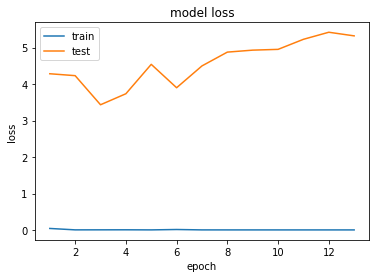

In [20]:
epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()